In [27]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using CUDA
using MLDatasets
using Plots

In [39]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true";

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 1000      ## number of epochs
    use_cuda::Bool = true   ## use gpu (if cuda available)
end
args = Args();

In [40]:
function encode16(x)
    e = zeros(Float32,7,7);
    for x_offset ∈ 0:6, y_offset ∈ 0:6
        x_ind = (4*x_offset+1):(4*x_offset+4)
        y_ind = (4*y_offset+1):(4*y_offset+4)
        block = x[x_ind,y_ind,1] .>=0.5
        e[x_offset+1,y_offset+1] = Float32.((Int32.(block.chunks[1]) .- 32768)./32768)
    end
    e
end;

In [41]:
## Load dataset. Reshape input data to flatten each image into a linear array
xtrain, ytrain = MLDatasets.MNIST(:train)[:];
xtest, ytest = MLDatasets.MNIST(:test)[:];
etrain = zeros(Float32,7,7,size(xtrain,3))
etest = zeros(Float32,7,7,size(xtest,3))

for ind ∈ 1:size(xtrain,3)
    etrain[:,:,ind] = encode16(xtrain[:,:,ind])
end
for ind ∈ 1:size(xtest,3)
    etest[:,:,ind] = encode16(xtest[:,:,ind])
end

xtrain = Flux.flatten(etrain);
xtest = Flux.flatten(etest);

## One-hot-encode the labels
ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9);

## Create two DataLoader objects (mini-batch iterators)
train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true);
test_loader = DataLoader((xtest, ytest), batchsize=args.batchsize);

In [42]:
function build_model(; imgsize=(7,7,1), nclasses=10)
    return Chain( Dense(prod(imgsize), 32, relu),
                  Dense(32, nclasses))
end;

In [43]:
function loss_and_accuracy(data_loader, model, device)
    acc = 0
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        x, y = device(x), device(y)
        ŷ = model(x)
        ls += logitcrossentropy(ŷ, y, agg=sum)
        acc += sum(onecold(ŷ) .== onecold(y)) ## Decode the output of the model
        num +=  size(x)[end]
    end
    return ls / num, acc / num
end;

In [62]:
## Train
CUDA.allowscalar(false)
device = gpu

## Construct model
model = build_model() |> device
ps = Flux.params(model) ## model's trainable parameters

## Optimizer
opt = ADAM(args.η)

Ltrain = []
Ltest = []
Atrain = []
Atest = []
## Training

@time for epoch in 1:args.epochs
    for (x, y) in train_loader
        x, y = device(x), device(y) ## transfer data to device
        gs = gradient(() -> logitcrossentropy(model(x), y), ps) ## compute gradient
        Flux.Optimise.update!(opt, ps, gs) ## update parameters
    end

    ## Report on train and test
    train_loss, train_acc = loss_and_accuracy(train_loader, model, device)
    test_loss, test_acc = loss_and_accuracy(test_loader, model, device)
    append!(Ltrain,train_loss)
    append!(Ltest,test_loss)
    append!(Atrain,train_acc)
    append!(Atest,test_acc)
    # println("Epoch=$epoch")
    # println("  train_loss = $train_loss, train_accuracy = $train_acc")
    # println("  test_loss = $test_loss, test_accuracy = $test_acc")
end

286.088683 seconds (576.90 M allocations: 61.202 GiB, 3.41% gc time, 0.06% compilation time)


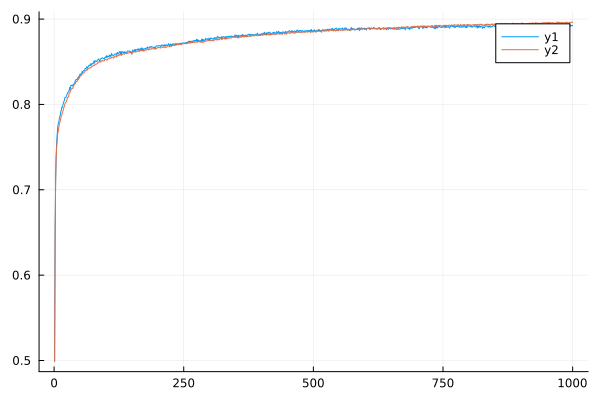

In [66]:
plt = plot(Atest)
plot!(plt,Atrain)

In [68]:
Atest[end],Atrain[end]

(0.8921, 0.8962333333333333)